In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import random
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from skimage.io import imsave

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-10-10 18:14:05.673729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760120045.925937      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760120046.002345      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_86.jpg
/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_19.jpg
/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_83.jpg
/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_26.jpg
/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_66.jpg
/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_65.jpg
/kaggle/input/histological-oral-cancer-image-dataset

In [2]:
base_paths = [
    "/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/First Set",
    "/kaggle/input/histological-oral-cancer-image-dataset/Histological Image Dataset/Second Set"
]

In [3]:
processed_folder = "/kaggle/working/processed"
aug_folder = "/kaggle/working/augmented"
final_folder = "/kaggle/working/final"
classes = ["Normal", "OSCC"]

In [4]:
for folder in [processed_folder, aug_folder, final_folder]:
    os.makedirs(folder, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(processed_folder, cls), exist_ok=True)

In [5]:
folders_map = {
    "100x Normal Oral Cavity Histopathological Images": "Normal",
    "100x OSCC Histopathological Images": "OSCC",
    "400x Normal Oral Cavity Histopathological Images": "Normal",
    "400x OSCC Histopathological Images": "OSCC",
}

In [6]:
target_size = (256, 256)
total_images = sum(
    len([f for f in os.listdir(os.path.join(bp, fn)) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
    for bp in base_paths for fn in os.listdir(bp) if fn in folders_map
)
pbar = tqdm(total=total_images, desc="Resizing Images", ncols=100)

sample_images = []  
for base_path in base_paths:
    for folder_name in os.listdir(base_path):
        if folder_name in folders_map:
            class_name = folders_map[folder_name]
            class_folder = os.path.join(processed_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)

            folder_path = os.path.join(base_path, folder_name)
            for idx, file in enumerate(os.listdir(folder_path)):
                if file.lower().endswith((".png", ".jpg", ".jpeg")):
                    src = os.path.join(folder_path, file)
                    dst = os.path.join(class_folder, f"{folder_name}_{idx}.png")

                    img = cv2.imread(src)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    imsave(dst, resized)

                    if len(sample_images) < 5:  # Keep 5 samples for preview
                        sample_images.append((img, resized, file, class_name))
                    pbar.update(1)

pbar.close()
print("All images resized and saved successfully!")

Resizing Images: 100%|██████████████████████████████████████████| 1224/1224 [01:57<00:00, 10.39it/s]

All images resized and saved successfully!


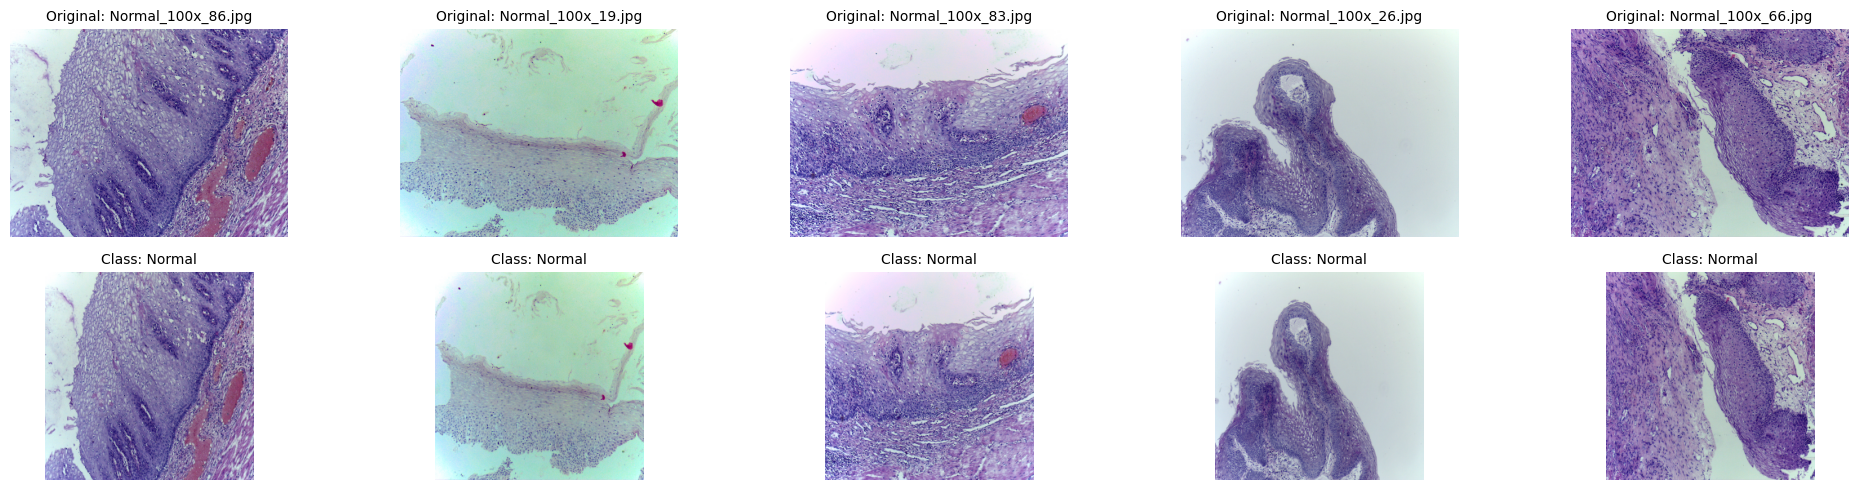

In [7]:
plt.figure(figsize=(20, 5))
for i, (original, resized, fname, cls_name) in enumerate(sample_images):
    plt.subplot(2, len(sample_images), i+1)
    plt.imshow(original)
    plt.axis('off')
    plt.title(f"Original: {fname}", fontsize=10)

    plt.subplot(2, len(sample_images), len(sample_images)+i+1)
    plt.imshow(resized)
    plt.axis('off')
    plt.title(f"Class: {cls_name}", fontsize=10)

plt.tight_layout()
plt.show()

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

N_aug = 3

for cls in classes:
    class_input = os.path.join(processed_folder, cls)
    class_output = os.path.join(aug_folder, cls)
    os.makedirs(class_output, exist_ok=True)

    files = [f for f in os.listdir(class_input) if f.endswith(".png")]
    for file in tqdm(files, desc=f"Augmenting {cls}"):
        img = tf.keras.preprocessing.image.load_img(os.path.join(class_input, file))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        imsave(os.path.join(class_output, f"{file[:-4]}_orig.png"), img_array.astype(np.uint8))

        for n in range(N_aug):
            aug_img = data_augmentation(tf.expand_dims(img_array, 0))
            aug_img = tf.squeeze(aug_img, 0).numpy().astype(np.uint8)
            imsave(os.path.join(class_output, f"{file[:-4]}_aug{n}.png"), aug_img)

I0000 00:00:1760120183.657460      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Augmenting OSCC: 100%|██████████| 934/934 [02:40<00:00,  5.81it/s]


In [9]:
counts_before = {cls: len(os.listdir(os.path.join(aug_folder, cls))) for cls in classes}
print("Counts before balancing:")
for cls, count in counts_before.items():
    print(f"  {cls}: {count} images")

Counts before balancing:
  Normal: 1160 images
  OSCC: 3736 images


In [10]:
counts = {cls: len(os.listdir(os.path.join(aug_folder, cls))) for cls in classes}
max_count = max(counts.values())

for cls in classes:
    class_path = os.path.join(aug_folder, cls)
    files = os.listdir(class_path)
    while len(files) < max_count:
        src = random.choice(files)
        dst = f"dup_{len(files)}.png"
        shutil.copyfile(os.path.join(class_path, src), os.path.join(class_path, dst))
        files.append(dst)
print("Classes balanced!")

Classes balanced!


In [11]:
counts_after = {cls: len(os.listdir(os.path.join(aug_folder, cls))) for cls in classes}
print("📈 Counts after balancing:")
for cls, count in counts_after.items():
    print(f"  {cls}: {count} images")

📈 Counts after balancing:
  Normal: 3736 images
  OSCC: 3736 images


In [12]:
for f in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(final_folder, f, cls), exist_ok=True)

for cls in classes:
    files = [f for f in os.listdir(os.path.join(aug_folder, cls)) if f.endswith(".png")]
    random.shuffle(files)
    n = len(files)
    n_train, n_val = int(0.7*n), int(0.15*n)
    splits = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }
    for split, split_files in splits.items():
        for f in split_files:
            shutil.copyfile(
                os.path.join(aug_folder, cls, f),
                os.path.join(final_folder, split, cls, f)
            )

print("Train, Val, Test sets created!")

Train, Val, Test sets created!


In [13]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)
data_dir = final_folder

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"), image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "val"), image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "test"), image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

normalization = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization(x), y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization(x), y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization(x), y)).cache().prefetch(AUTOTUNE)

print("Datasets ready for training!")

Found 5230 files belonging to 2 classes.
Found 1120 files belonging to 2 classes.
Found 1122 files belonging to 2 classes.
Datasets ready for training!


Model: "AOX_Model_Modified_BN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,048 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│                     │ 128)              │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ multiply[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 525,890 (2.01 MB)

 Trainable params: 524,930 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

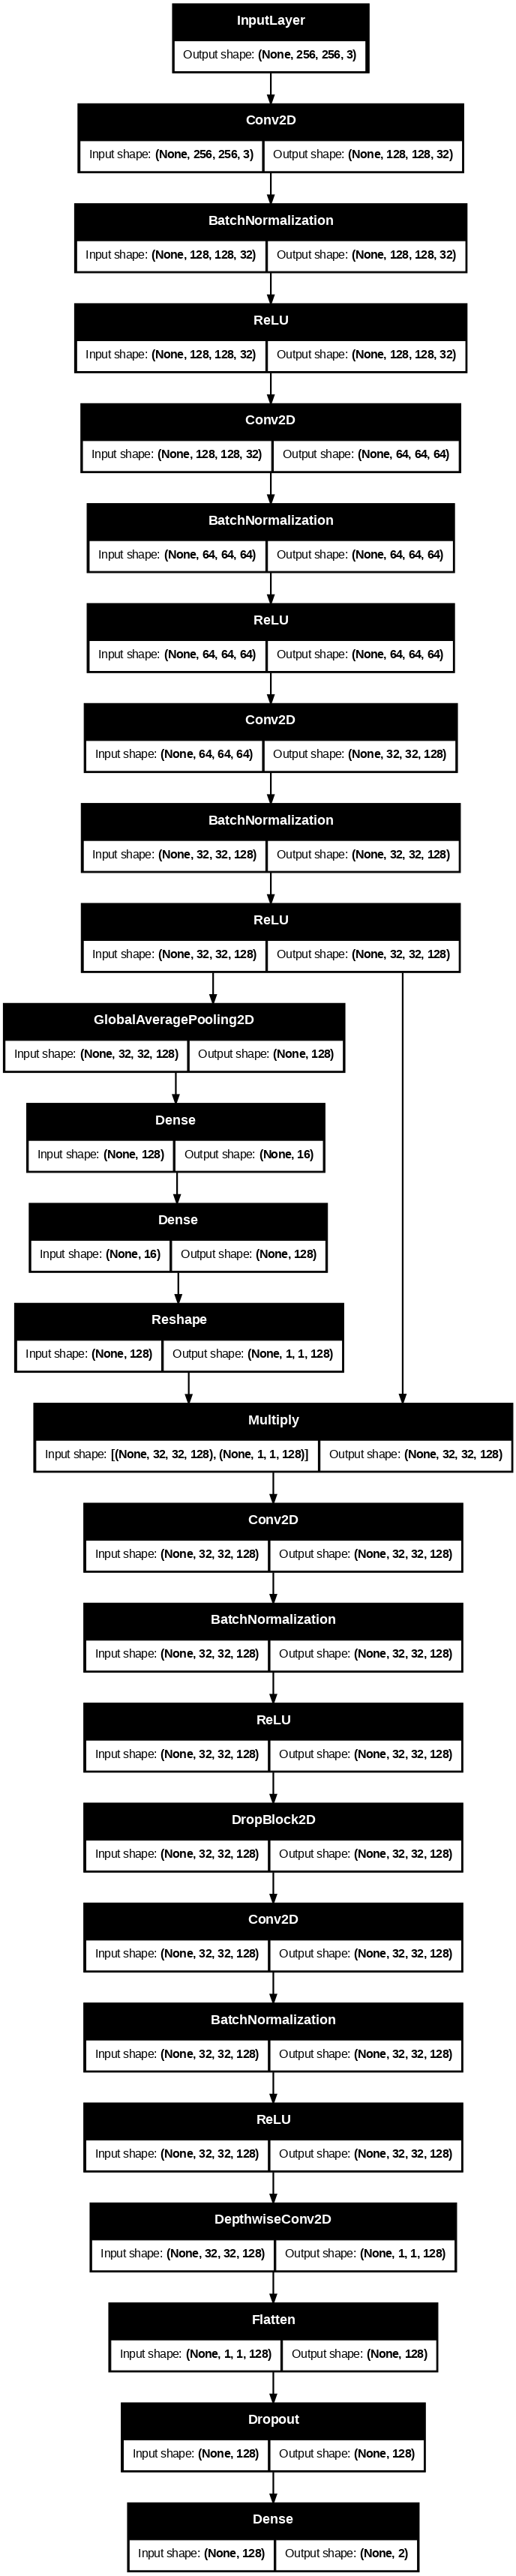

In [14]:
class DropBlock2D(layers.Layer):
    def __init__(self, drop_prob=0.1, block_size=7, **kwargs):
        super(DropBlock2D, self).__init__(**kwargs)
        self.drop_prob = drop_prob
        self.block_size = block_size

    def call(self, x, training=None):
        if not training or self.drop_prob == 0.0:
            return x
        h, w = x.shape[1], x.shape[2]
        gamma = self.drop_prob * (h * w) / (self.block_size**2) / ((h - self.block_size + 1) * (w - self.block_size + 1))
        mask = tf.cast(tf.random.uniform((tf.shape(x)[0], h, w, 1)) < gamma, x.dtype)
        mask = tf.nn.max_pool2d(mask, ksize=self.block_size, strides=1, padding="SAME")
        mask = 1 - mask
        x = x * mask * (tf.cast(tf.size(mask), tf.float32) / tf.reduce_sum(mask))
        return x


def SEBlockKeras(input_tensor, reduction=8):
    channels = int(input_tensor.shape[-1])
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu', use_bias=False)(se)
    se = layers.Dense(channels, activation='sigmoid', use_bias=False)(se)
    se = layers.Reshape((1, 1, channels))(se)
    x = layers.Multiply()([input_tensor, se])
    return x


def AOX_Model_Keras_Modified(input_shape=(256,256,3), num_classes=2, drop_prob=0.1):
    inputs = keras.Input(shape=input_shape)

    # Use existing data augmentation
    x = inputs

    # Conv Layers + BatchNorm + Activation
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Squeeze-Excitation Block
    x = SEBlockKeras(x, reduction=8)

    # More Conv + DropBlock + BatchNorm
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = DropBlock2D(drop_prob=drop_prob, block_size=5)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Global Depthwise Conv + Flatten
    spatial_size = x.shape[1]  # current height
    x = layers.DepthwiseConv2D(kernel_size=spatial_size, padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)

    # Dropout before classifier
    x = layers.Dropout(0.4)(x)

    # Final Dense
    # outputs = layers.Dense(num_classes, activation='softmax')(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="AOX_Model_Modified_BN")
    return model


model = AOX_Model_Keras_Modified(input_shape=(256,256,3), drop_prob=0.1)
model.summary()
keras.utils.plot_model(model, expand_nested=True, dpi=80, show_shapes=True)

In [15]:
EPOCHS = 50
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint("/kaggle/working/best_aox_model.h5", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)
model.save("/kaggle/working/final_aox_model_keras.h5")
print("Model saved.")

Epoch 1/50


I0000 00:00:1760120414.719028     103 service.cc:148] XLA service 0x28254320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760120414.720029     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760120415.421153     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/327 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5384 - loss: 0.6883   

I0000 00:00:1760120420.553886     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


327/327 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.6550 - loss: 0.6101 - val_accuracy: 0.5170 - val_loss: 0.9154 - learning_rate: 1.0000e-04
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7815 - loss: 0.4686 - val_accuracy: 0.8205 - val_loss: 0.4052 - learning_rate: 1.0000e-04
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8407 - loss: 0.3814 - val_accuracy: 0.8750 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 4/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8864 - loss: 0.2963 - val_accuracy: 0.8857 - val_loss: 0.2670 - learning_rate: 1.0000e-04
Epoch 5/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9126 - loss: 0.2386 - val_accuracy: 0.8884 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 6/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9444 - loss: 0.1825 - val_accuracy: 0.9071 - val_loss: 0.2283 - learning_rate: 1.0000e-04
Epoch 7/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9

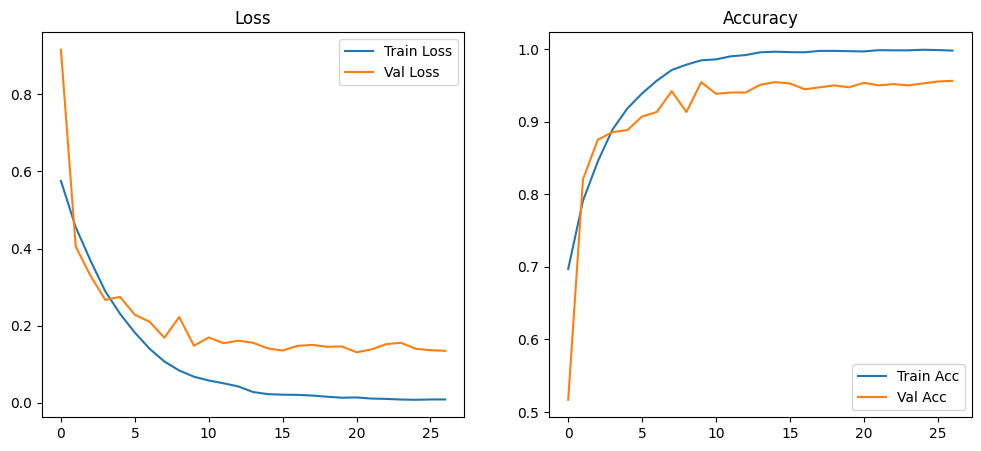

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9544 - loss: 0.1234
Test Accuracy: 0.9688
Test Loss: 0.1007


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Test Accuracy: 0.9688
Classification Report:
              precision    recall  f1-score   support

  NON CANCER       0.97      0.96      0.97       561
      CANCER       0.96      0.97      0.97       561

    accuracy                           0.97      1122
   macro avg       0.97      0.97      0.97      112

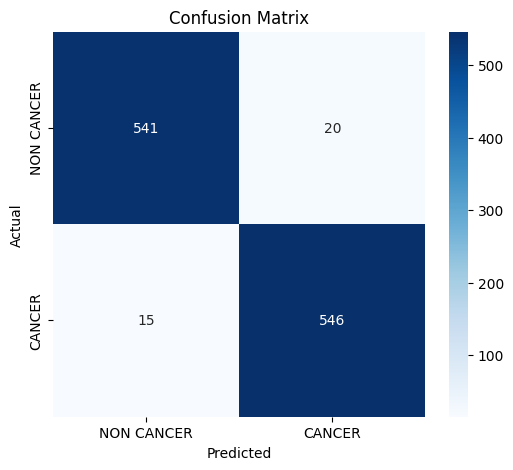

Keras pipeline finished. Model, plots and architecture diagram saved in /kaggle/working/


In [18]:
import seaborn as sns

y_true = []
y_pred = []

for x_batch, y_batch in test_ds.unbatch().batch(64):
    preds = model.predict(x_batch)           
    y_true.extend(y_batch.numpy().tolist())  
    y_pred.extend(np.argmax(preds, axis=1))  

test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

class_names = ["NON CANCER", "CANCER"]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Keras pipeline finished. Model, plots and architecture diagram saved in /kaggle/working/")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


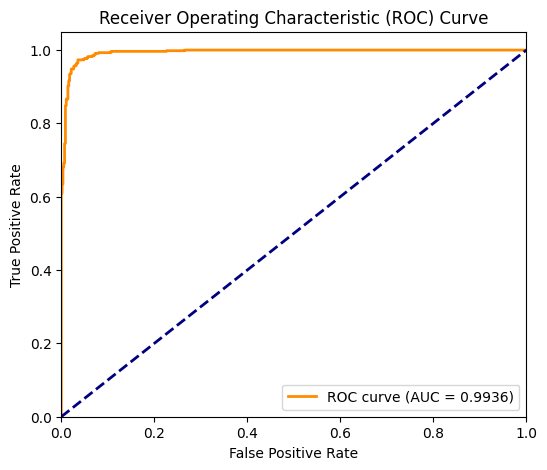

ROC AUC: 0.9936


In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_true_list = []
y_pred_probs_list = []

for x_batch, y_batch in test_ds.unbatch().batch(64):
    probs = model.predict(x_batch)       
    y_pred_probs_list.extend(probs[:, 1]) 
    y_true_list.extend(y_batch.numpy())

y_true = np.array(y_true_list)
y_pred_probs = np.array(y_pred_probs_list)

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")

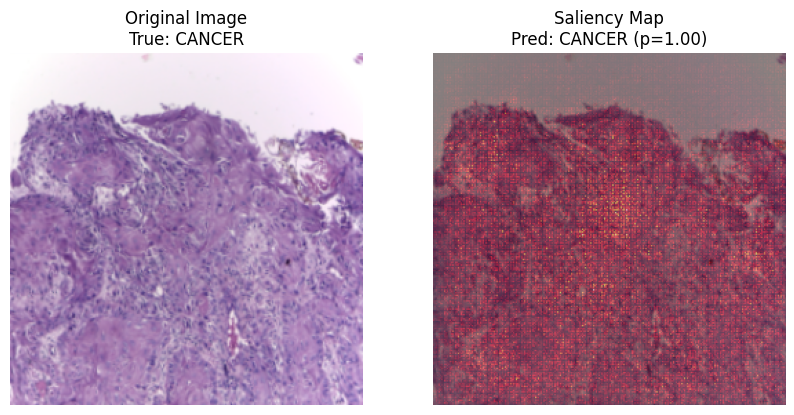

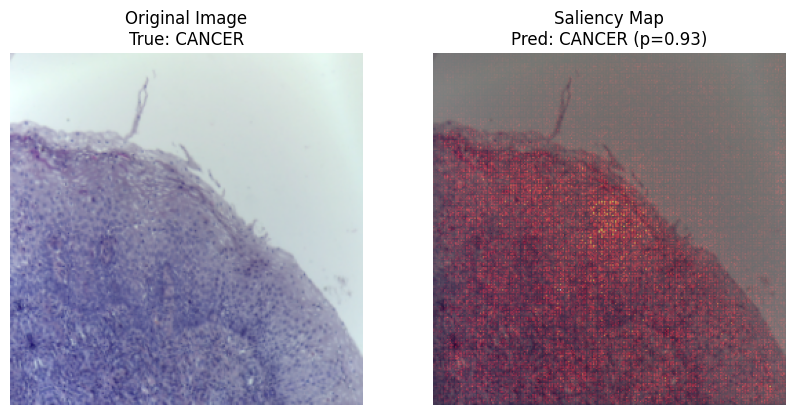

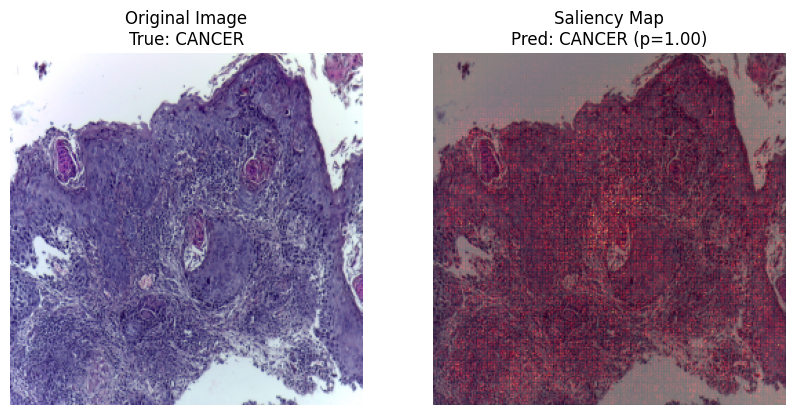

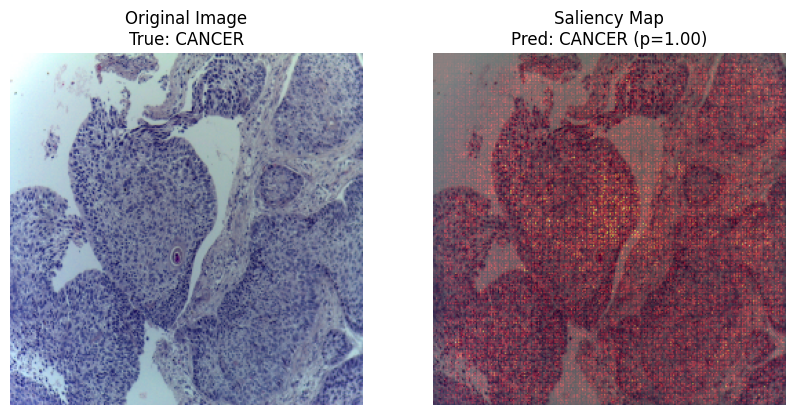

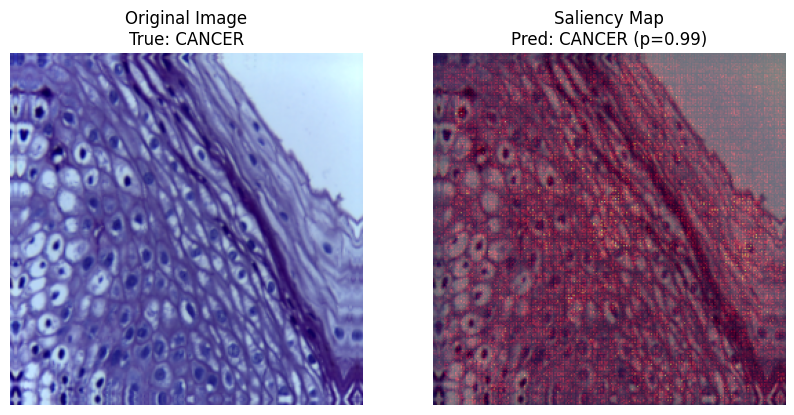

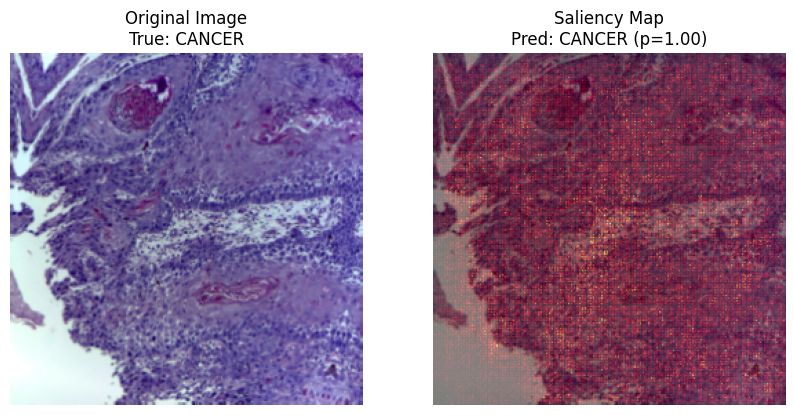

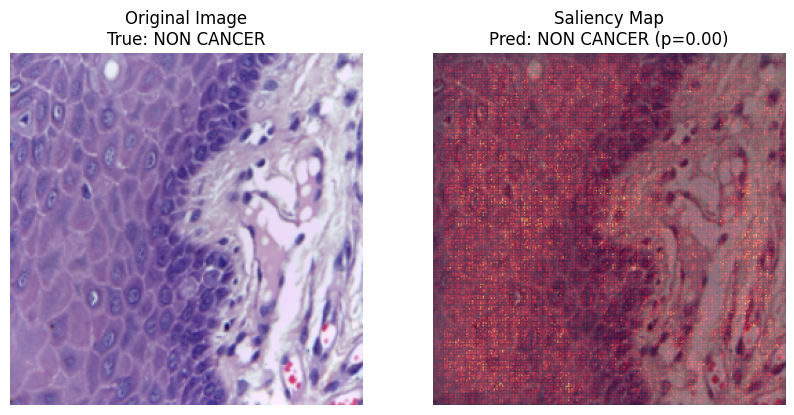

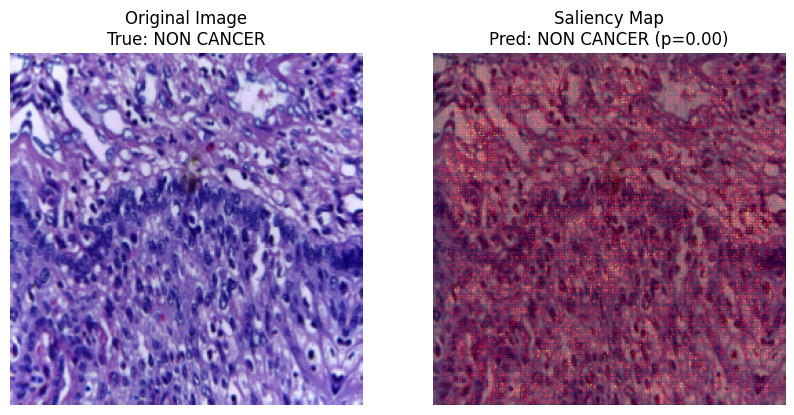

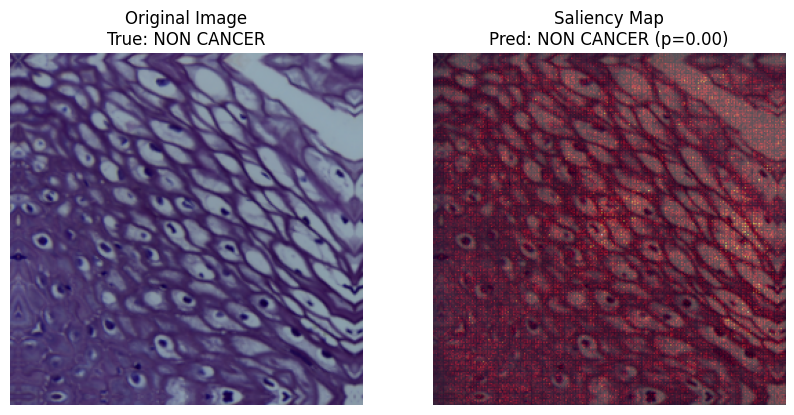

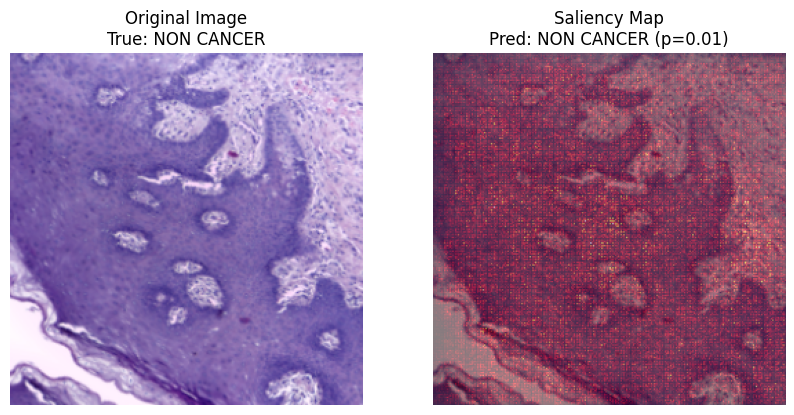

In [20]:
def compute_saliency(model, img_array, class_index=None):
    img_array = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_array)
        preds = model(img_array)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, img_array)
    saliency = tf.abs(grads)
    saliency = tf.reduce_max(saliency, axis=-1)
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)
    return saliency.numpy().squeeze()


test_images = list(test_ds.unbatch()) 
random_samples = random.sample(test_images, 10)

for i, (img_tensor, label_tensor) in enumerate(random_samples):
    img_array = img_tensor[tf.newaxis, ...]

    saliency_map = compute_saliency(model, img_array)

    img = img_tensor.numpy()
    heatmap = plt.cm.hot(saliency_map)[..., :3]
    superimposed_img = np.clip(0.5 * img + 0.5 * heatmap, 0, 1)

    pred_probs = model.predict(img_array, verbose=0)[0]
    pred_prob = pred_probs[1]                # positive class probability
    pred_label = np.argmax(pred_probs)       # predicted class index

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original Image\nTrue: {class_names[label_tensor.numpy()]}")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f"Saliency Map\nPred: {class_names[pred_label]} (p={pred_prob:.2f})")

    plt.show()
